# Chapter 10: Low Flow Stats

[JP Gannon](https://jpgannon.github.io/)
[](https://orcid.org/0000-0002-4595-3214)
([Virginia Tech](https://www.vt.edu/))  
2026-02-09

# Low Flow Analysis

**Pre-activity reading:**

<https://www.epa.gov/ceam/definition-and-characteristics-low-flows#1Q10>

**Analysis based on:**

<https://github.com/DEQdsobota/Oregon7Q10/blob/master/R/Oregon7Q10.R>

<https://nepis.epa.gov/Exe/ZyPDF.cgi?Dockey=P100BK6P.txt>

*Load packages for analysis. zoo will allow us to easily perform rolling
means, and moments will allow easy calculation of skewness.*

In [1]:
library(zoo)
library(tidyverse)
library(dataRetrieval)
library(lubridate)
library(moments)

theme_set(theme_classic())

Warning message:
"package 'zoo' was built under R version 4.3.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'tidyverse' was built under R version 4.3.3"
Warning message:
"package 'readr' was built under R version 4.3.3"
Warning message:
"package 'dplyr' was built under R version 4.3.3"
Warning message:
"package 'forcats' was built under R version 4.3.3"
Warning message:
"package 'lubridate' was built under R version 4.3.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib

## What are low flow statistics?

Low flow design flows can be specified based on hydrological or
biological data. Biological methods look more at water quality standards
relevant to biota. The hydrologic method just looks at the statistical
distribution of low flows over a period of time.

-   Just from this simple definition, can you think of a management
    situation where it would make sense to use the biological method?
    the hydrologic method? What are the advantages to each?

We will focus on hydrologic methods. What a surprise! You will most
frequently see low flow stats in the format of xQy. So for example 7Q10
or 1Q10 are common design flows. Let’s look at the EPA definition of
these and then break them down.

“The 1Q10 and 7Q10 are both hydrologically based design flows. The 1Q10
is the lowest 1-day average flow that occurs (on average) once every 10
years. The 7Q10 is the lowest 7-day average flow that occurs (on
average) once every 10 years.” -EPA
<https://www.epa.gov/ceam/definition-and-characteristics-low-flows#1Q10>

So the first number, **the 7 in 7Q10** is how many days we will average
flow over to calculate the statistic. Why does does this matter? Why not
always use a 1 day flow record?

Then the second number is the return-interval of the flow, or the
probability that a flow of that magnitude or lower will occur any given
year. **The 10 in 7Q10** means there is a 10 percent chance that the
associated 7-day average flow or below will occur in any given year.
Another way of saying this is that a flow of that magnitude or below
occurs on average once every 10 years. **However** expressing it this
way can be dangerous, especially with the opposite type of extreme
flows: Floods. Why do you think it could be dangerous to say a flow of
this magnitude or below will happen on average once every 10 years?

**So, to calculate a 7Q10** we need: \* 7-day mean-daily flows \* The
minimum value per year of those 7-day mean-daily flows \* The return
intervals of those minimum yearly flows

**Because a 7Q10 flow means** \* There is a 10% chance (return interval
= 10) that a river will have a average weekly flow of that level or
below in a given year.

## Get data

Let’s get started on an example. We will calculate the 7Q10 low flow
statistic for the Linville NC usgs gage (02138500) using daily discharge
data from 1922-1984. (parameter = 00060)

In [2]:
siteno <- "02138500"
startDate <- "1922-01-01"
endDate <- "1984-01-01"
parameter <- "00060"

Qdat <- readNWISdv(siteno, parameter, startDate, endDate) |> 
  renameNWISColumns()


Warning message:
"NWIS servers are slated for decommission. Please begin to migrate to read_waterdata_daily."
GET: https://waterservices.usgs.gov/nwis/dv/?site=02138500&format=waterml%2C1.1&ParameterCd=00060&StatCd=00003&startDT=1922-01-01&endDT=1984-01-01


## Create the X days average flow record

Remember the 7 in 7Q10 means we are looking at the 7-day average flow.
We just have daily values from the USGS gage, so we need to create this
data record.

To do this we will calculate a rolling average, also called a
moving-window average. This just means you grab the first 7 days,
average them, then move the window of the days you are averaging forward
a day, and average again… all the way through the record.

For your rolling mean you can have the window look forward, backward, or
forward and backward. For example, a forward window takes the average of
X number of records and places the value at the beginning. Backward
places that value at the end, and both would put it in the middle. In
the function we will use to do this, forward is a left align, backward
is right align, and both is centered.

**For example**

> data window = 1, 2, 3, 4, 5 (lots of values before and after this)

> mean = 3

> forward window/left align: 3, NA, NA, NA, NA

> backward window/right align: NA, NA, NA, NA, 3

> both/center align: NA, NA, 3, NA, NA

We could certainly set up some code to calculate this, but there is a
nice and fast function in the zoo package for calculating rolling means.

As we write the code to do this analysis, we are going to keep in mind
that we may want to calculate a different type of low flow, like a 1Q10,
so we are going to store the x and y of the xQy low flow statistic as
objects rather than including them several places in the code. That way
we can just change them in one place and run the analysis to compute a
different statistic.

In [3]:
#set x and y for xQy design flow
Xday <- 7
YrecInt <- 10

#X day rolling mean, don't fill the ends of the timeseries,
#don't ignore NAs, use a backward-looking window (right align)
Qdat <- Qdat |> mutate(xdaymean = rollmean(Flow, 
                                            Xday, 
                                            fill = NA, 
                                            na.rm = F, 
                                            align = "right"))

## Look at what a rolling mean does.

We just added a new column with the rolling mean, so let’s plot it and
see what it did to the discharge record.

Let’s look at June-August 1960. You can’t see too well what is going on
in the full record.

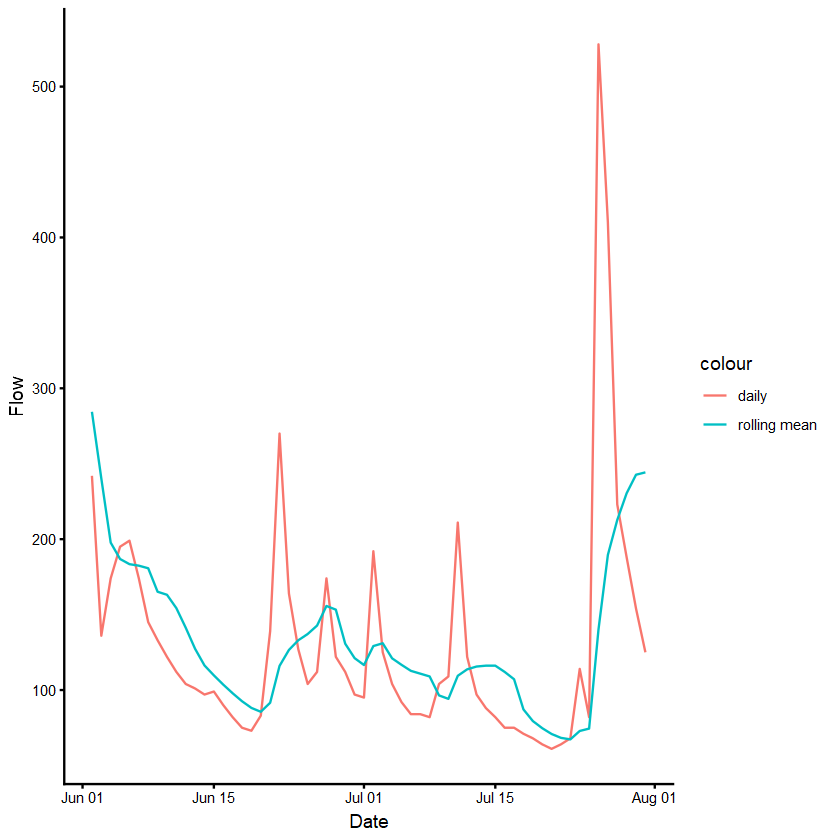

In [4]:
Qdat |> 
  filter(Date > mdy("06-01-1960") & Date < mdy("08-01-1960")) |>
  ggplot(aes(Date, Flow, color = "daily"))+
    geom_line()+
    geom_line(aes(x = Date, y = xdaymean, color = "rolling mean"))

## Calculate yearly minimums

Okay, we have our X-day rolling mean. Now we need to calculate the
probability that a given magnitude flow or below will happen in a given
year. Because we are concerned with *a given year* we need the lowest
flow per year.

We will calculate minimum flow per year by creating a *Year* column,
grouping by that column, and using the summarize function to calculate
the minimum flow per year. The code we are going to write will also drop
any years that are missing too much data by dropping years missing 10%
or more days.

In [5]:
#missing less than 10% of each year and 10% or fewer NAs
QyearlyMins <- Qdat |> mutate(year = year(Date)) |>
                        group_by(year) |>
                        summarize(minQ = min(xdaymean, na.rm = T), 
                                  lenDat = length(Flow),
                                  lenNAs = sum(is.na(xdaymean))) |>
                        filter(lenDat > 328 & lenNAs / lenDat < 0.1) 

## Calculate return interval

Now that we have an object that contains our yearly minimum flows, we
can calculate the return interval as

$Return Interval = (n + 1) / rank$

Where n is the number of records in the data (number of years) and rank
is the rank of each year’s low flow (lowest flow = rank 1 and so on). We
can calculate the rank with the rank() function in base R. In the rank
function we will specify that in the case of a tie, the first value gets
the lower rank using ties.method = “first”.

We can then transform that to an exceedence probability as

$Exceedence Probability = 1 / Return Interval$

Once we calculate the return interval and exceedence probability we will
plot the return interval against the minimum discharge.

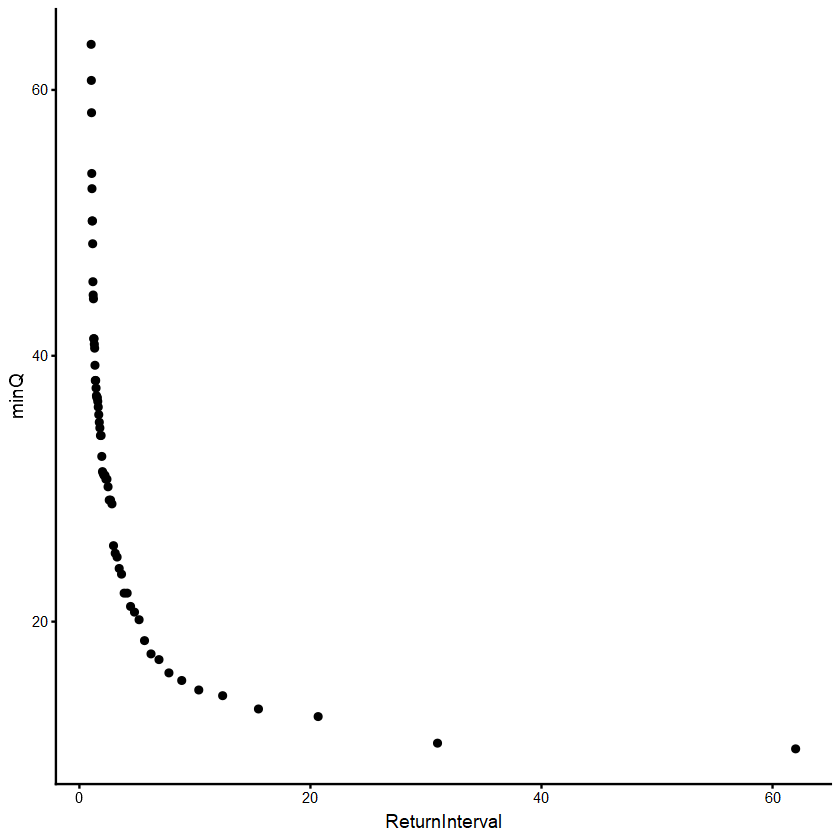

In [6]:
# add rank column and return interval column
QyearlyMins <- QyearlyMins |> 
                mutate(rank = rank(minQ, ties.method = "first")) |>
                mutate(ReturnInterval = (length(rank) + 1)/rank) |>
                mutate(ExceedProb = 1 / ReturnInterval)
      
ggplot(QyearlyMins, aes(x = ReturnInterval, y = minQ))+
  geom_point()

**Challenge question** How is this similar to a flow duration curve?
Could you make a “flow duration curve” from these data? What would it
tell you?

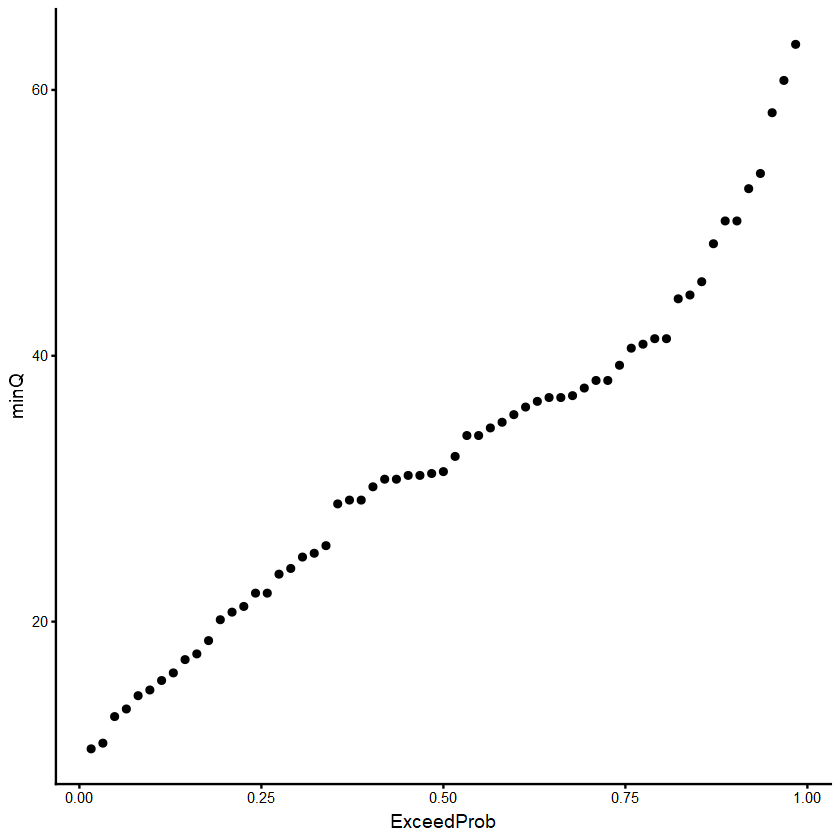

In [7]:
ggplot(QyearlyMins, aes(x = ExceedProb, y = minQ))+
  geom_point()

## Fit to Pearson Type II distribution

Source for these calculations:
<https://water.usgs.gov/osw/bulletin17b/dl_flow.pdf>

We now have everything we need to calculate what the 10-year return
interval flow is (the 0.1 probability flow). To do this, we have to fit
a distribution to our data and then use that fitted distribution to
predict the value of the 10-year return interval flow.

This may sound a little complex, but let’s think about it this way:

-   You have some data, let’s say: heights of students at Virginia Tech
-   You did some tests on it and know it is a normal distribution
-   If you measure the mean and standard deviation of that distribution,
    you could create a “fitted” representation of your distrubtion by
    generating a normal distribution with the same mean and standard
    deviation with the rnorm() function.
-   Now you could plot that fitted, synthetic distribution as an ECDF
    and read the plot to determine, say, 10% of students (0.1
    probability) are at or above what height?

Assume the average height from your data was 65 inches and the standard
deviation was 6 inches (this is 100% made up), let’s look at it.

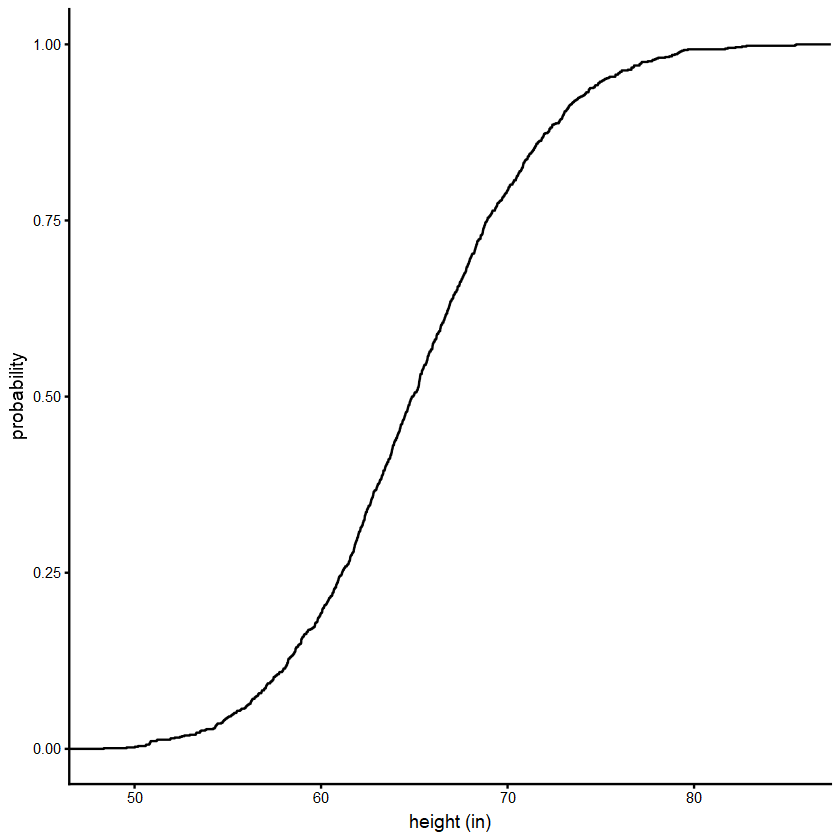

In [8]:
fitteddistribution <- rnorm(1000, mean = 65, sd = 6) |>
  as_tibble()

ggplot(fitteddistribution, aes(x = value))+
  stat_ecdf()+
  xlab("height (in)")+
  ylab("probability")

To get our 10 year return period (0.1 exceedence probability) we are
going to do the same thing, except we know the distribution of the data
isn’t normal, so we have to use a different distribution.

There are a bunch of “extreme value” distributions used in these type of
analyses. When we talk about floods we will use the Gumbel distribution,
for example. For this type of analysis, it is common to use the Pearson
Type III distribution.

When we used the normal distribution example, we let R produce the
distribution that fit our data. In this case we will use the equation
that describes the Pearson Type III distribution. To predict flow at a
given recurrence interval we will need the mean of the logged discharges
(Xbar), the frequency factor (K), the standard deviation of the log
discharges (S), skewness (g), and the standard normal variate (z). We
will first compute this for all of the values in our data set to see how
the fitted values fit our calculated values.

**Pearson Type III**

$Flow = exp(Xbar + KS)$

where:

Xbar = mean of the log discharge you are investigating

K = frequency factor

S = standard deviation of log discharges

**Frequency Factor**

$K = (2 / g) * ((1 +( g * z)) / 6 - ((g ^ 2) / 36)) ^ 3 - 1)$

**Skewness**

g = skewness() from moments package

**Standard normal variate**

$z = 4.91 * ((1 / y) ^ {0.14} - (1 - (1 / y)) ^ {0.14})$

y = recurrence interval

In [9]:
#Measures of the distribution
Xbar <- mean(log(QyearlyMins$minQ))
S    <- sd(log(QyearlyMins$minQ))
g    <- skewness(log(QyearlyMins$minQ))
 
#calculate z, K, to plot the fitted Pearson Type III
QyearlyMins <- QyearlyMins |> 
  mutate(z = 4.91 * ((1 / ReturnInterval) ^ 0.14 - (1 - 1 / ReturnInterval) ^ 0.14)) |>
  mutate(K = (2 / g) * (((1 + (g * z) / 6 - (g ^ 2) / 36) ^ 3) - 1) ) |>
  mutate(Qfit = exp(Xbar + K * S))

Let’s look our results and see how they fit. Plot the return interval on
the x axis and flow on the y. Plot minQ, the minimum Q data, and Qfit,
the data from the the model fit.

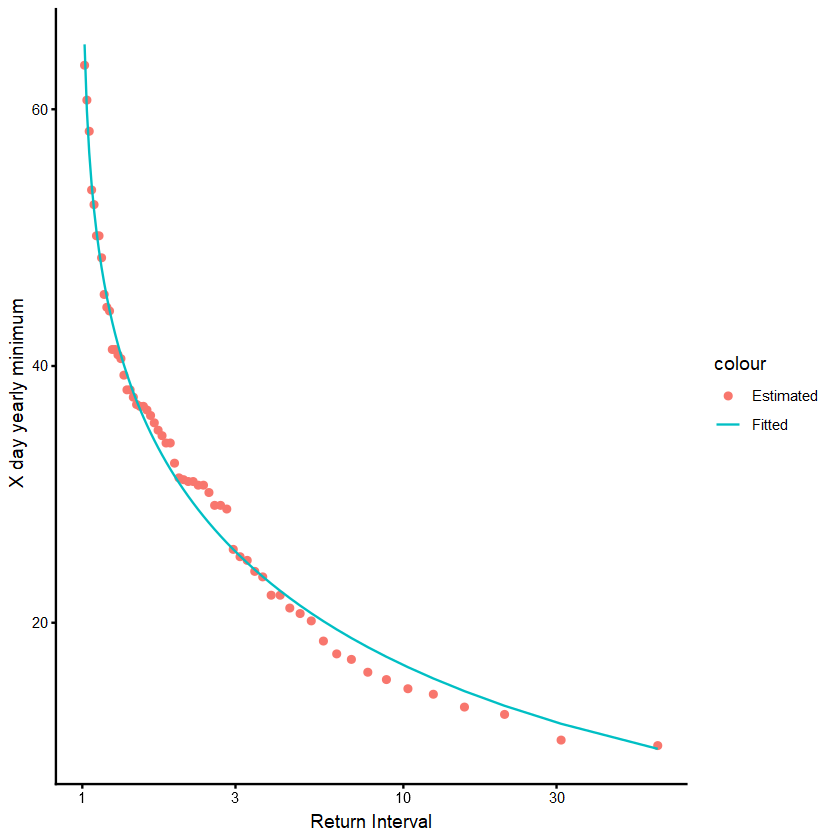

In [10]:
QyearlyMins |> 
  ggplot(aes(x = ReturnInterval, y = minQ, color = "Estimated"))+
  geom_point()+
  geom_line(aes(x = ReturnInterval, y = Qfit, color = "Fitted"))+
  theme_classic()+
  scale_x_log10()+
  ylab("X day yearly minimum")+
  xlab("Return Interval")

Above we calculated z, K and the flow for each return interval in our
data record to see how the distribution fit our data. We can see it fits
quite well.

We can use the same calculations as we used on the entire record to
calculate a specific return period of interest. In our case, the 10 year
return period for the 7Q10.

We will set y equal to YrecInt, which we set above. This way we can just
change it at the top of the code to run whatever xQy metric we want.

In [11]:
#xQy ei: 7Q10
y <- YrecInt

#Find these values based on established relationships
z    <- 4.91 * ((1 / y) ^ 0.14 - (1 - 1 / y) ^ 0.14)
K    <- (2 / g) * (((1 + (g * z) / 6 - (g ^ 2) / 36) ^ 3) - 1) 

PearsonxQy <- exp(Xbar + K * S)

So, our 7Q10 flow in cfs for this gage is….

In [12]:
#Low flow stat (7Q10 in exercise)
PearsonxQy

16.7048826126519

## Distribution-free method

We won’t go over this in the same detail, but the xQy flow can also be
calculated using a formula that does not assume a specific distribution.
The expression, and code to perform it, is below.

**The expression for xQy is:**

$xQy = (1-e) X(m1) + eX(m2)$

where: \[ \] indicates the value is truncated

$X(m)$ = the m-th lowest annual low flow of record

$m1 = [(n+1)/y]$

$m2 = [(n+l)/y] + 1$

$[z]$ = the largest integer less than or equal to z

$e = (n+l)/y - [(n+l)/y]$

This method is only appropriate when the desired return period is less
than n/5 years

In [13]:
x <- Xday
y <- YrecInt
n <- length(QyearlyMins$minQ)

m1 <- trunc((n + 1)/y)
m2 <- trunc(((n + 1)/y) + 1)

e <- ((n + 1)/y) - m1

Xm1 <- QyearlyMins$minQ[QyearlyMins$rank == m1]
Xm2 <- QyearlyMins$minQ[QyearlyMins$rank == m2]

DFxQy <- (1-e) * Xm1 + e * Xm2

DFxQy

15